### Trend forecasting trading system using tecnical idicators <br> 
#### Ability to backtest strategy - make sure this is False if wanting to see daily buys/sells <br> Note: everything will show as negative returns unless backtest == True is on (positions not closed out)

In [ ]:
import pandas as pd
import os
import pickle
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

backtest_on = False

In [193]:
# Load player database
data_dir = r'/Users/joshualowe/Documents/Misc/Football_Index/00_Data/00_global_player_database/'
os.chdir(data_dir)

def load_obj(file_name):
    with open(file_name + '.pkl', 'rb') as f:
        return pickle.load(f)

df = load_obj('FI_global_player_price_data_full_prem_v5')

In [194]:
# 8 24
Lfast = 8
Lslow = 32

names_to_remove = []
for name, data in df.items(): 

    # remove items with no data
    if data.avgPrice.isna().sum() > 1:
        names_to_remove.append(name)
    
    data['fast_ewma'] = data['avgPrice'].ewm(span=Lfast).mean()
    data['slow_ewma'] = data['avgPrice'].ewm(span=Lslow).mean()
    data['EWMAC'] = data['fast_ewma'] - data['slow_ewma']
    
    # round EWMAC to 2dp
    data['EWMAC_rounded'] = data['EWMAC'].round(2)
       
#     plt.figure(figsize=(18,5))
#     plt.plot(data['DateTime'], data['avgPrice'])
    
#     plt.plot(data['DateTime'], data['fast_ewma'])
#     plt.plot(data['DateTime'], data['slow_ewma'])
# #     plt.plot(data['DateTime'], data['Volume']/100)
#     plt.title(name)
#     plt.legend(loc='best')
#     plt.show()

for n in names_to_remove:
    df.pop(n)


#### Position determination using my custom decision system

In [195]:
spend_per_player = 100
commision        = 0.02
window           = 5
ewmac_threshold  = 0

returns = []

# Position determination
for name, data in df.items(): 
    
    # add row at the start to intiate position step 1/2
    data = pd.concat([data.iloc[0:1,:], data], ignore_index=True).copy()
    
    data['volatility'] = data['avgPrice'].rolling(window).mean()
    
    data['EWMAC_%_price'] = (100/data['avgPrice']) * data['EWMAC']
    
    data['position'] = np.where(data['EWMAC_%_price'] > ewmac_threshold, 'Long', "Short")
    # add row at the start to intiate position step 2/2
    data.loc[0,'position'] = 'Short'
    data.loc[0,'DateTime'] = 'Dummy Row'
    
    data['change'] = np.where(data['position'] == 'Long', 1, 0).astype(int)
    data['change'] = data['change'].diff()

    data['position_lots'] = (spend_per_player / data['avgPrice']).round(0)
    data['position_lots'] = np.where(abs(data['change'])>0, data['position_lots'], np.nan)
    data['position_lots'] =  data['position_lots'].fillna(method='ffill')

    data['position_lots'] = np.where(data['change']==-1, -data['position_lots'].shift(1),
                                     data['position_lots'])
    data['position_lots'] = np.where(abs(data['change'])>0, data['position_lots'], np.nan)
        
    
    data['position_money']       = (data['position_lots'] * data['avgPrice']) *-1
    data['transaction_costs']    = np.where(data['position_money'] > 0, data['position_lots'] *commision , 0)
    data['position_money_final'] = data['position_money'] + data['transaction_costs']
    
    
    # Close out positions to show total returns
    if backtest_on == True:
        length = data.shape[0] - 1 # loc -1 was not working
        if data.loc[length,'change'] == 1:
            data.loc[length,'position_money_final'] = 0
        if data.loc[length,'change'] == 0 and data.loc[length,'position'] == 'Long':
            data.loc[length,'position_lots'] = -data['position_lots'][data['position_lots'].last_valid_index()]
            # then repeat the calc's to get MTM
            data['position_money']       = (data['position_lots'] * data['avgPrice']) *-1
            data['transaction_costs']    = np.where(data['position_money'] > 0, data['position_lots'] *commision , 0)
            data['position_money_final'] = data['position_money'] + data['transaction_costs']
    
    
    df[name] = data.copy()
    print(('returns over over the last 30 days: %.2f and mean volatility: %.2f  - ') % (data['position_money_final'].sum(), data['volatility'].mean()) + name)
    
    returns.append([name, data['avgPrice'].mean(), data['position_money'].abs().sum() / 2., data['transaction_costs'].sum(), 
                    data['position_money_final'].sum(), data['volatility'].mean()])


returns = pd.DataFrame(returns, columns=['player', 'avg price', 'spend', 'costs', '£ return', 'avg Volatility'])


returns over over the last 30 days: 6.48 and mean volatility: 1.32  - lucas
returns over over the last 30 days: 0.00 and mean volatility: 0.21  - ganso
returns over over the last 30 days: -99.84 and mean volatility: 0.33  - yuri
returns over over the last 30 days: -11.88 and mean volatility: 0.49  - allan
returns over over the last 30 days: -11.55 and mean volatility: 0.25  - neto
returns over over the last 30 days: 0.00 and mean volatility: 0.17  - franco-di-santo
returns over over the last 30 days: 0.00 and mean volatility: 0.18  - michel
returns over over the last 30 days: 10.80 and mean volatility: 0.95  - alisson
returns over over the last 30 days: -8.30 and mean volatility: 0.92  - pedrinho
returns over over the last 30 days: -8.95 and mean volatility: 0.56  - marcelo
returns over over the last 30 days: 0.00 and mean volatility: 0.24  - vitor-hugo
returns over over the last 30 days: -7.84 and mean volatility: 0.50  - lucas-lima
returns over over the last 30 days: 0.00 and mean vo

avg price           1053.780302
spend             185589.745000
costs              -6955.060000
£ return          -93072.830000
avg Volatility      1053.819600
dtype: float64


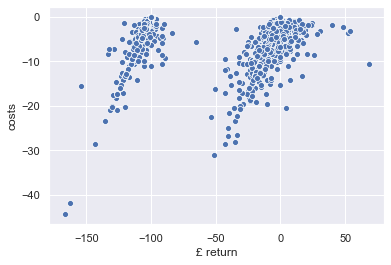

In [196]:
print(returns.iloc[:,1:].sum())
sns.scatterplot(returns['£ return'], returns['costs'])

avg price           560.224574
spend             53403.545000
costs              -811.300000
£ return         -22132.390000
avg Volatility      560.369622
dtype: float64


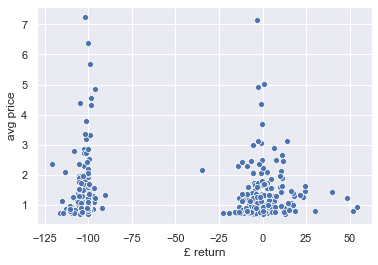

In [197]:
subset = returns[returns['avg price'] > 0.7]
print(subset.iloc[:,1:].sum())
sns.scatterplot(subset['£ return'], subset['avg price'])

In [198]:
# walk through an example
# df['serge-aurier']

In [199]:
# Action Alert
buys  = []
sells = []
for name, data in df.items(): 
    # get todays row
    tmp = data[data['DateTime'] != 'Dummy Row']
    tmp['DateTime'] = pd.to_datetime(tmp['DateTime'])
    tmp['Player'] = name
    
    tmp_buys  = tmp[(tmp['DateTime'] == pd.Timestamp('today').normalize()) & (tmp['position_lots'] > 0) & (tmp['avgPrice'] >= 0.7)]
    tmp_sells = tmp[(tmp['DateTime'] == pd.Timestamp('today').normalize()) & (tmp['position_lots'] < 0) & (tmp['avgPrice'] > 0.7)]
    
    # get todays action
    buys.append(tmp_buys[['Player', 'DateTime', 'avgPrice', 'EWMAC_%_price', 'volatility', 'position_lots']])
    sells.append(tmp_sells[['Player', 'DateTime', 'avgPrice', 'EWMAC_%_price', 'volatility', 'position_lots']])
    
buys = pd.concat(buys)
sells = pd.concat(sells)

/Users/joshualowe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/joshualowe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [200]:
display(buys)
display(sells)

'''
Stratergy
- Player price over £0.5    maybe this helps the short term trading strat as the cheap players are less liquid
- EWMAC_%_price over 0%     scalled to a % as the price for different players has a big range
- '''

,Player,DateTime,avgPrice,EWMAC_%_price,volatility,position_lots


,Player,DateTime,avgPrice,EWMAC_%_price,volatility,position_lots


'\nStratergy\n- Player price over £0.5    maybe this helps the short term trading strat as the cheap players are less liquid\n- EWMAC_%_price over 0%     scalled to a % as the price for different players has a big range\n- '

In [201]:
# Portfolio
portfolio = ['ravel-morrison', 'juan-foyth',
             'alexandre-lacazette', 'andreas-pereira',
             'dani-ceballos', 'eddie-nketiah','jack-grealish',
             'richarlison', 'virgil-van-dijk',
             'harry-kane','ainsley-maitland-niles','reece-james',
             'romelu-lukaku', 'harry-maguire',
             'ousmane-dembele', 'nicolò-barella', 'kasper-dolberg',
             'dani-olmo','pietro-pellegri',
             'jean-philippe-mateta', 'florian-neuhaus', 'nabil-fekir',
             'jonathan-tah', 'philippe-coutinho','federico-chiesa',
             'jordan-veretout','david-brooks', 'breel-embolo',
             'han-noah-massengo', 'dele-alli', 'gareth-bale','brahim-diaz','marc-roca',
             'michy-batshuayi', 'eljif-elmas','ferrán-torres','rodrigo-bentancur','erick-pulgar',
             'sandro-tonali', 'emile-smith-rowe','ismaila-sarr',
             'bobby-duncan','curtis-jones','james-justin','john-yeboah',
             'carlos-soler','ryan-kent','dwight-mcneil','rafael-leão',
             'diogo-dalot','hamza-choudhury','kristoffer-ajer','bruno-fernandes',
             'n-golo-kant%c3%a9']

cols_ = ['DateTime','Volume','avgPrice','EWMAC_%_price','position','position_lots']
portfolio_dict = dict((k, df[k].loc[52:][cols_]) for k in portfolio if k in df)

for name, data in portfolio_dict.items():
    print('---------------------------------')
    display(name)
    display(data)
    print('---------------------------------')

---------------------------------


'ravel-morrison'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,24.00,1.33,1.169839,Long,NaN
53,2019-08-30 00:00:00,27.00,1.33,1.219347,Long,NaN
54,2019-08-31 00:00:00,25.00,1.33,1.238650,Long,NaN
55,2019-09-01 00:00:00,25.00,1.33,1.235678,Long,NaN
56,2019-09-02 00:00:00,24.00,1.32,1.104725,Long,NaN
57,2019-09-03 00:00:00,13.00,1.32,0.987165,Long,NaN
58,2019-09-04 00:00:00,18.00,1.32,0.887832,Long,NaN
59,2019-09-05 00:00:00,11.00,1.32,0.803172,Long,NaN
60,2019-09-06 00:00:00,13.00,1.32,0.730387,Long,NaN
61,2019-09-07 00:00:00,8.00,1.32,0.667272,Long,NaN


---------------------------------
---------------------------------


'juan-foyth'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,12.00,0.92,1.141988,Long,NaN
53,2019-08-30 00:00:00,8.00,0.91,0.974682,Long,NaN
54,2019-08-31 00:00:00,11.00,0.91,0.830035,Long,NaN
55,2019-09-01 00:00:00,8.00,0.91,0.713073,Long,NaN
56,2019-09-02 00:00:00,13.00,0.91,0.617927,Long,NaN
57,2019-09-03 00:00:00,10.00,0.91,0.540011,Long,NaN
58,2019-09-04 00:00:00,7.00,0.91,0.475744,Long,NaN
59,2019-09-05 00:00:00,13.00,0.90,0.249167,Long,NaN
60,2019-09-06 00:00:00,8.00,0.91,0.251684,Long,NaN
61,2019-09-07 00:00:00,13.00,0.92,0.423521,Long,NaN


---------------------------------
---------------------------------


'alexandre-lacazette'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,84.00,1.47,2.653343,Long,NaN
53,2019-08-30 00:00:00,93.00,1.47,2.428327,Long,NaN
54,2019-08-31 00:00:00,207.00,1.49,2.414805,Long,NaN
55,2019-09-01 00:00:00,898.00,1.56,3.004160,Long,NaN
56,2019-09-02 00:00:00,211.00,1.53,3.226815,Long,NaN
57,2019-09-03 00:00:00,103.00,1.52,3.218548,Long,NaN
58,2019-09-04 00:00:00,88.00,1.51,3.067820,Long,NaN
59,2019-09-05 00:00:00,65.00,1.51,2.900224,Long,NaN
60,2019-09-06 00:00:00,63.00,1.51,2.738203,Long,NaN
61,2019-09-07 00:00:00,56.00,1.51,2.582498,Long,NaN


---------------------------------
---------------------------------


'andreas-pereira'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,19.0,0.90,3.228233,Long,NaN
53,2019-08-30 00:00:00,17.0,0.89,2.606718,Long,NaN
54,2019-08-31 00:00:00,418.0,0.97,3.233691,Long,NaN
55,2019-09-01 00:00:00,23.0,0.85,2.087146,Long,NaN
56,2019-09-02 00:00:00,12.0,0.85,0.888769,Long,NaN
57,2019-09-03 00:00:00,16.0,0.85,0.002095,Long,NaN
58,2019-09-04 00:00:00,10.0,0.84,-0.843104,Short,-159.0
59,2019-09-05 00:00:00,8.0,0.84,-1.448414,Short,NaN
60,2019-09-06 00:00:00,11.0,0.84,-1.870386,Short,NaN
61,2019-09-07 00:00:00,5.0,0.84,-2.152814,Short,NaN


---------------------------------
---------------------------------


'dani-ceballos'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,147.0,2.39,11.223007,Long,NaN
53,2019-08-30 00:00:00,178.0,2.38,10.401269,Long,NaN
54,2019-08-31 00:00:00,189.0,2.38,9.623975,Long,NaN
55,2019-09-01 00:00:00,479.0,2.39,8.953797,Long,NaN
56,2019-09-02 00:00:00,229.0,2.38,8.339120,Long,NaN
57,2019-09-03 00:00:00,151.0,2.38,7.748606,Long,NaN
58,2019-09-04 00:00:00,183.0,2.36,7.136933,Long,NaN
59,2019-09-05 00:00:00,248.0,2.35,6.504545,Long,NaN
60,2019-09-06 00:00:00,157.0,2.36,5.974514,Long,NaN
61,2019-09-07 00:00:00,168.0,2.38,5.614280,Long,NaN


---------------------------------
---------------------------------


'eddie-nketiah'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,230.0,1.76,4.861272,Long,NaN
53,2019-08-30 00:00:00,134.0,1.76,4.646382,Long,NaN
54,2019-08-31 00:00:00,228.0,1.75,4.359709,Long,NaN
55,2019-09-01 00:00:00,172.0,1.74,4.002827,Long,NaN
56,2019-09-02 00:00:00,130.0,1.73,3.597981,Long,NaN
57,2019-09-03 00:00:00,107.0,1.72,3.162145,Long,NaN
58,2019-09-04 00:00:00,68.0,1.72,2.785444,Long,NaN
59,2019-09-05 00:00:00,79.0,1.71,2.393208,Long,NaN
60,2019-09-06 00:00:00,254.0,1.74,2.302859,Long,NaN
61,2019-09-07 00:00:00,184.0,1.76,2.392236,Long,NaN


---------------------------------
---------------------------------


'jack-grealish'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,163.00,2.10,-1.197551,Short,NaN
53,2019-08-30 00:00:00,126.00,2.08,-1.386011,Short,NaN
54,2019-08-31 00:00:00,152.00,2.08,-1.495984,Short,NaN
55,2019-09-01 00:00:00,157.00,2.07,-1.640239,Short,NaN
56,2019-09-02 00:00:00,119.00,2.06,-1.803545,Short,NaN
57,2019-09-03 00:00:00,107.00,2.05,-1.979336,Short,NaN
58,2019-09-04 00:00:00,135.00,2.04,-2.162630,Short,NaN
59,2019-09-05 00:00:00,78.00,2.02,-2.440537,Short,NaN
60,2019-09-06 00:00:00,65.00,2.02,-2.594340,Short,NaN
61,2019-09-07 00:00:00,101.00,2.02,-2.671128,Short,NaN


---------------------------------
---------------------------------


'richarlison'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,98.00,1.89,-1.462282,Short,NaN
53,2019-08-30 00:00:00,86.00,1.89,-1.655612,Short,NaN
54,2019-08-31 00:00:00,118.00,1.89,-1.773820,Short,NaN
55,2019-09-01 00:00:00,910.00,1.97,-1.112949,Short,NaN
56,2019-09-02 00:00:00,272.00,1.98,-0.583954,Short,NaN
57,2019-09-03 00:00:00,118.00,1.97,-0.276150,Short,NaN
58,2019-09-04 00:00:00,122.00,1.97,-0.045573,Short,NaN
59,2019-09-05 00:00:00,74.00,1.97,0.123331,Long,51.0
60,2019-09-06 00:00:00,70.00,1.97,0.244921,Long,NaN
61,2019-09-07 00:00:00,88.00,1.97,0.330322,Long,NaN


---------------------------------
---------------------------------


'virgil-van-dijk'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,542.00,3.10,0.652805,Long,NaN
53,2019-08-30 00:00:00,352.00,3.09,0.493666,Long,NaN
54,2019-08-31 00:00:00,304.00,3.08,0.318645,Long,NaN
55,2019-09-01 00:00:00,423.00,3.07,0.134011,Long,NaN
56,2019-09-02 00:00:00,451.00,3.05,-0.108071,Short,-33.0
57,2019-09-03 00:00:00,400.00,3.05,-0.283878,Short,NaN
58,2019-09-04 00:00:00,248.00,3.04,-0.462243,Short,NaN
59,2019-09-05 00:00:00,259.00,3.03,-0.640160,Short,NaN
60,2019-09-06 00:00:00,232.00,3.02,-0.815690,Short,NaN
61,2019-09-07 00:00:00,198.00,3.02,-0.931111,Short,NaN


---------------------------------
---------------------------------


'harry-kane'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,559.00,4.89,0.514977,Long,NaN
53,2019-08-30 00:00:00,450.00,4.89,0.334646,Long,NaN
54,2019-08-31 00:00:00,585.00,4.90,0.230618,Long,NaN
55,2019-09-01 00:00:00,1252.00,4.91,0.184240,Long,NaN
56,2019-09-02 00:00:00,765.00,4.89,0.083486,Long,NaN
57,2019-09-03 00:00:00,587.00,4.88,-0.024471,Short,-21.0
58,2019-09-04 00:00:00,439.00,4.87,-0.136101,Short,NaN
59,2019-09-05 00:00:00,471.00,4.87,-0.215669,Short,NaN
60,2019-09-06 00:00:00,670.00,4.87,-0.270791,Short,NaN
61,2019-09-07 00:00:00,2497.00,4.93,-0.108554,Short,NaN


---------------------------------
---------------------------------


'ainsley-maitland-niles'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,22.0,0.87,1.186208,Long,NaN
53,2019-08-30 00:00:00,24.0,0.87,0.691019,Long,NaN
54,2019-08-31 00:00:00,24.0,0.87,0.320242,Long,NaN
55,2019-09-01 00:00:00,46.0,0.87,0.045319,Long,NaN
56,2019-09-02 00:00:00,33.0,0.86,-0.343448,Short,-123.0
57,2019-09-03 00:00:00,26.0,0.84,-1.018225,Short,NaN
58,2019-09-04 00:00:00,23.0,0.83,-1.701402,Short,NaN
59,2019-09-05 00:00:00,32.0,0.83,-2.167732,Short,NaN
60,2019-09-06 00:00:00,13.0,0.82,-2.703961,Short,NaN
61,2019-09-07 00:00:00,8.0,0.82,-3.039093,Short,NaN


---------------------------------
---------------------------------


'reece-james'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,122.0,1.82,8.034284,Long,NaN
53,2019-08-30 00:00:00,102.0,1.82,7.680783,Long,NaN
54,2019-08-31 00:00:00,117.0,1.83,7.364148,Long,NaN
55,2019-09-01 00:00:00,300.0,1.87,7.252696,Long,NaN
56,2019-09-02 00:00:00,244.0,1.93,7.459737,Long,NaN
57,2019-09-03 00:00:00,192.0,1.95,7.758148,Long,NaN
58,2019-09-04 00:00:00,155.0,1.95,7.925333,Long,NaN
59,2019-09-05 00:00:00,183.0,1.97,8.020657,Long,NaN
60,2019-09-06 00:00:00,117.0,1.98,8.079457,Long,NaN
61,2019-09-07 00:00:00,80.0,1.97,8.000938,Long,NaN


---------------------------------
---------------------------------


'romelu-lukaku'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,287.0,2.07,9.890249,Long,NaN
53,2019-08-30 00:00:00,323.0,2.09,9.808055,Long,NaN
54,2019-08-31 00:00:00,479.0,2.13,9.799552,Long,NaN
55,2019-09-01 00:00:00,880.0,2.20,9.989044,Long,NaN
56,2019-09-02 00:00:00,971.0,2.28,10.419411,Long,NaN
57,2019-09-03 00:00:00,516.0,2.30,10.890801,Long,NaN
58,2019-09-04 00:00:00,746.0,2.34,11.234343,Long,NaN
59,2019-09-05 00:00:00,767.0,2.39,11.561963,Long,NaN
60,2019-09-06 00:00:00,1169.0,2.33,11.706173,Long,NaN
61,2019-09-07 00:00:00,370.0,2.20,11.162762,Long,NaN


---------------------------------
---------------------------------


'harry-maguire'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,331.0,2.52,2.135937,Long,NaN
53,2019-08-30 00:00:00,310.0,2.53,1.595731,Long,NaN
54,2019-08-31 00:00:00,668.0,2.51,1.068177,Long,NaN
55,2019-09-01 00:00:00,555.0,2.47,0.411502,Long,NaN
56,2019-09-02 00:00:00,345.0,2.45,-0.217014,Short,-37.0
57,2019-09-03 00:00:00,211.0,2.44,-0.743399,Short,NaN
58,2019-09-04 00:00:00,233.0,2.44,-1.116690,Short,NaN
59,2019-09-05 00:00:00,162.0,2.44,-1.373825,Short,NaN
60,2019-09-06 00:00:00,159.0,2.43,-1.614953,Short,NaN
61,2019-09-07 00:00:00,311.0,2.42,-1.838257,Short,NaN


---------------------------------
---------------------------------


'ousmane-dembele'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,73.0,2.36,-2.082644,Short,NaN
53,2019-09-05 00:00:00,75.0,2.35,-2.115933,Short,NaN
54,2019-09-06 00:00:00,72.0,2.34,-2.181721,Short,NaN
55,2019-09-07 00:00:00,53.0,2.34,-2.193080,Short,NaN
56,2019-09-08 00:00:00,48.0,2.33,-2.249085,Short,NaN
57,2019-09-09 00:00:00,2.4,2.33,-2.252196,Short,NaN


---------------------------------
---------------------------------


'nicolò-barella'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,48.0,1.19,4.821780,Long,NaN
53,2019-09-05 00:00:00,60.0,1.20,4.844126,Long,NaN
54,2019-09-06 00:00:00,10.0,1.19,4.729465,Long,NaN
55,2019-09-07 00:00:00,24.0,1.19,4.550989,Long,NaN
56,2019-09-08 00:00:00,27.0,1.19,4.358185,Long,NaN
57,2019-09-09 00:00:00,1.8,1.19,4.157640,Long,NaN


---------------------------------
---------------------------------


'kasper-dolberg'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,67.0,1.19,12.726539,Long,NaN
53,2019-09-05 00:00:00,126.0,1.19,12.606532,Long,NaN
54,2019-09-06 00:00:00,46.0,1.15,12.219868,Long,NaN
55,2019-09-07 00:00:00,28.0,1.16,11.488478,Long,NaN
56,2019-09-08 00:00:00,102.0,1.16,10.873708,Long,NaN
57,2019-09-09 00:00:00,2.0,1.16,10.275769,Long,NaN


---------------------------------
---------------------------------


'dani-olmo'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,47.0,1.35,0.725834,Long,NaN
53,2019-09-05 00:00:00,35.0,1.36,0.234514,Long,NaN
54,2019-09-06 00:00:00,68.0,1.38,0.109651,Long,NaN
55,2019-09-07 00:00:00,36.0,1.39,0.134208,Long,NaN
56,2019-09-08 00:00:00,32.0,1.40,0.263872,Long,NaN
57,2019-09-09 00:00:00,2.0,1.40,0.355564,Long,NaN


---------------------------------
---------------------------------


'pietro-pellegri'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,28.0,1.30,0.368943,Long,NaN
53,2019-09-05 00:00:00,17.0,1.30,-0.078553,Short,-78.0
54,2019-09-06 00:00:00,17.0,1.29,-0.530679,Short,NaN
55,2019-09-07 00:00:00,21.0,1.28,-0.984145,Short,NaN
56,2019-09-08 00:00:00,22.0,1.27,-1.434456,Short,NaN
57,2019-09-09 00:00:00,1.2,1.27,-1.737697,Short,NaN


---------------------------------
---------------------------------


'jean-philippe-mateta'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,21.0,0.95,1.870071,Long,NaN
53,2019-09-05 00:00:00,16.0,0.95,2.207088,Long,NaN
54,2019-09-06 00:00:00,8.0,0.94,2.278635,Long,NaN
55,2019-09-07 00:00:00,11.0,0.95,2.426310,Long,NaN
56,2019-09-08 00:00:00,13.0,0.96,2.658354,Long,NaN
57,2019-09-09 00:00:00,0.0,0.96,2.809613,Long,NaN


---------------------------------
---------------------------------


'florian-neuhaus'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,140.0,0.94,-1.346551,Short,NaN
53,2019-09-05 00:00:00,26.0,0.95,-0.543086,Short,NaN
54,2019-09-06 00:00:00,11.0,0.95,0.040202,Long,105.0
55,2019-09-07 00:00:00,13.0,0.95,0.465207,Long,NaN
56,2019-09-08 00:00:00,10.0,0.94,0.607167,Long,NaN
57,2019-09-09 00:00:00,0.8,0.94,0.698807,Long,NaN


---------------------------------
---------------------------------


'nabil-fekir'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,102.0,2.19,5.898330,Long,NaN
53,2019-09-05 00:00:00,49.0,2.19,5.897005,Long,NaN
54,2019-09-06 00:00:00,75.0,2.19,5.814726,Long,NaN
55,2019-09-07 00:00:00,99.0,2.19,5.674632,Long,NaN
56,2019-09-08 00:00:00,99.0,2.18,5.446313,Long,NaN
57,2019-09-09 00:00:00,7.6,2.18,5.185915,Long,NaN


---------------------------------
---------------------------------


'jonathan-tah'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,27.0,1.27,-4.339803,Short,NaN
53,2019-09-05 00:00:00,28.0,1.27,-4.551251,Short,NaN
54,2019-09-06 00:00:00,38.0,1.28,-4.481891,Short,NaN
55,2019-09-07 00:00:00,33.0,1.27,-4.555799,Short,NaN
56,2019-09-08 00:00:00,15.0,1.27,-4.521331,Short,NaN
57,2019-09-09 00:00:00,0.8,1.27,-4.434086,Short,NaN


---------------------------------
---------------------------------


'philippe-coutinho'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,80.0,2.17,1.510574,Long,NaN
53,2019-09-05 00:00:00,78.0,2.16,1.281648,Long,NaN
54,2019-09-06 00:00:00,112.0,2.16,1.091868,Long,NaN
55,2019-09-07 00:00:00,92.0,2.16,0.938373,Long,NaN
56,2019-09-08 00:00:00,86.0,2.16,0.813472,Long,NaN
57,2019-09-09 00:00:00,4.2,2.16,0.711159,Long,NaN


---------------------------------
---------------------------------


'federico-chiesa'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,78.0,1.85,3.255359,Long,NaN
53,2019-09-05 00:00:00,161.0,1.87,3.285212,Long,NaN
54,2019-09-06 00:00:00,59.0,1.86,3.219026,Long,NaN
55,2019-09-07 00:00:00,54.0,1.86,3.113527,Long,NaN
56,2019-09-08 00:00:00,60.0,1.86,2.993736,Long,NaN
57,2019-09-09 00:00:00,2.2,1.87,2.935368,Long,NaN


---------------------------------
---------------------------------


'jordan-veretout'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,9.0,0.81,-0.351084,Short,NaN
53,2019-09-05 00:00:00,7.0,0.81,-0.199043,Short,NaN
54,2019-09-06 00:00:00,2.0,0.81,-0.085383,Short,NaN
55,2019-09-07 00:00:00,2.0,0.81,-0.001283,Short,NaN
56,2019-09-08 00:00:00,3.0,0.81,0.060099,Long,123.0
57,2019-09-09 00:00:00,0.0,0.81,0.104064,Long,NaN


---------------------------------
---------------------------------


'david-brooks'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,109.0,1.80,2.265129,Long,NaN
53,2019-08-30 00:00:00,44.0,1.81,2.646498,Long,NaN
54,2019-08-31 00:00:00,61.0,1.81,2.897350,Long,NaN
55,2019-09-01 00:00:00,73.0,1.80,2.968695,Long,NaN
56,2019-09-02 00:00:00,58.0,1.80,2.968185,Long,NaN
57,2019-09-03 00:00:00,54.0,1.80,2.927049,Long,NaN
58,2019-09-04 00:00:00,42.0,1.80,2.856878,Long,NaN
59,2019-09-05 00:00:00,56.0,1.80,2.766521,Long,NaN
60,2019-09-06 00:00:00,31.0,1.80,2.662704,Long,NaN
61,2019-09-07 00:00:00,57.0,1.80,2.550515,Long,NaN


---------------------------------
---------------------------------


'breel-embolo'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,120.0,1.00,10.501514,Long,NaN
53,2019-09-05 00:00:00,117.0,1.04,11.189154,Long,NaN
54,2019-09-06 00:00:00,96.0,1.07,11.946568,Long,NaN
55,2019-09-07 00:00:00,145.0,1.11,12.685967,Long,NaN
56,2019-09-08 00:00:00,343.0,1.10,13.341437,Long,NaN
57,2019-09-09 00:00:00,8.2,1.05,13.436524,Long,NaN


---------------------------------
---------------------------------


'han-noah-massengo'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,24.0,0.98,6.652368,Long,NaN
53,2019-09-05 00:00:00,14.0,0.98,6.253093,Long,NaN
54,2019-09-06 00:00:00,11.0,0.97,5.771762,Long,NaN
55,2019-09-07 00:00:00,11.0,0.97,5.294084,Long,NaN
56,2019-09-08 00:00:00,12.0,0.97,4.872749,Long,NaN
57,2019-09-09 00:00:00,0.2,0.97,4.498376,Long,NaN


---------------------------------
---------------------------------


'dele-alli'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,125.00,1.94,2.270498,Long,NaN
53,2019-08-30 00:00:00,77.00,1.94,2.111873,Long,NaN
54,2019-08-31 00:00:00,99.00,1.94,1.967033,Long,NaN
55,2019-09-01 00:00:00,217.00,1.94,1.834275,Long,NaN
56,2019-09-02 00:00:00,117.00,1.93,1.638294,Long,NaN
57,2019-09-03 00:00:00,93.00,1.93,1.465851,Long,NaN
58,2019-09-04 00:00:00,74.00,1.92,1.243462,Long,NaN
59,2019-09-05 00:00:00,56.00,1.91,0.980288,Long,NaN
60,2019-09-06 00:00:00,63.00,1.91,0.770036,Long,NaN
61,2019-09-07 00:00:00,63.00,1.91,0.606039,Long,NaN


---------------------------------
---------------------------------


'gareth-bale'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,153.0,2.10,0.069663,Long,NaN
53,2019-09-05 00:00:00,205.0,2.10,0.075150,Long,NaN
54,2019-09-06 00:00:00,454.0,2.12,0.227825,Long,NaN
55,2019-09-07 00:00:00,187.0,2.09,0.112327,Long,NaN
56,2019-09-08 00:00:00,116.0,2.08,-0.052555,Short,-47.0
57,2019-09-09 00:00:00,5.4,2.08,-0.172544,Short,NaN


---------------------------------
---------------------------------


'brahim-diaz'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,62.00,1.28,0.771252,Long,NaN
53,2019-08-30 00:00:00,37.00,1.29,0.949119,Long,NaN
54,2019-08-31 00:00:00,26.00,1.29,1.070151,Long,NaN
55,2019-09-01 00:00:00,23.00,1.29,1.143719,Long,NaN
56,2019-09-02 00:00:00,22.00,1.28,1.066112,Long,NaN
57,2019-09-03 00:00:00,41.00,1.30,1.219036,Long,NaN
58,2019-09-04 00:00:00,16.00,1.30,1.325883,Long,NaN
59,2019-09-05 00:00:00,32.00,1.30,1.385694,Long,NaN
60,2019-09-06 00:00:00,23.00,1.30,1.410382,Long,NaN
61,2019-09-07 00:00:00,17.00,1.29,1.295815,Long,NaN


---------------------------------
---------------------------------


'marc-roca'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,6.0,0.75,0.953836,Long,NaN
53,2019-09-05 00:00:00,9.0,0.75,0.518847,Long,NaN
54,2019-09-06 00:00:00,9.0,0.75,0.194362,Long,NaN
55,2019-09-07 00:00:00,5.0,0.75,-0.045054,Short,-125.0
56,2019-09-08 00:00:00,7.0,0.75,-0.219124,Short,NaN
57,2019-09-09 00:00:00,0.2,0.75,-0.343136,Short,NaN


---------------------------------
---------------------------------


'michy-batshuayi'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,17.0,0.83,-4.252114,Short,NaN
53,2019-08-30 00:00:00,12.0,0.83,-4.443104,Short,NaN
54,2019-08-31 00:00:00,15.0,0.82,-4.770782,Short,NaN
55,2019-09-01 00:00:00,27.0,0.81,-5.162224,Short,NaN
56,2019-09-02 00:00:00,25.0,0.80,-5.600217,Short,NaN
57,2019-09-03 00:00:00,13.0,0.79,-6.071533,Short,NaN
58,2019-09-04 00:00:00,25.0,0.79,-6.280466,Short,NaN
59,2019-09-05 00:00:00,30.0,0.80,-6.067480,Short,NaN
60,2019-09-06 00:00:00,316.0,0.89,-3.671456,Short,NaN
61,2019-09-07 00:00:00,22.0,0.84,-3.412172,Short,NaN


---------------------------------
---------------------------------


'eljif-elmas'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,15.0,0.94,0.379568,Long,NaN
53,2019-09-05 00:00:00,22.0,0.94,0.109226,Long,NaN
54,2019-09-06 00:00:00,0.0,0.94,-0.089498,Short,-102.0
55,2019-09-07 00:00:00,12.0,0.94,-0.233252,Short,NaN
56,2019-09-08 00:00:00,14.0,0.92,-0.689458,Short,NaN
57,2019-09-09 00:00:00,0.0,0.92,-1.009188,Short,NaN


---------------------------------
---------------------------------


'ferrán-torres'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,15.0,1.21,-1.214917,Short,NaN
53,2019-09-05 00:00:00,20.0,1.21,-1.431943,Short,NaN
54,2019-09-06 00:00:00,23.0,1.20,-1.716503,Short,NaN
55,2019-09-07 00:00:00,19.0,1.20,-1.891772,Short,NaN
56,2019-09-08 00:00:00,25.0,1.19,-2.144625,Short,NaN
57,2019-09-09 00:00:00,0.4,1.19,-2.288081,Short,NaN


---------------------------------
---------------------------------


'rodrigo-bentancur'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,4.0,0.71,-1.577663,Short,NaN
53,2019-09-05 00:00:00,8.0,0.71,-1.848824,Short,NaN
54,2019-09-06 00:00:00,8.0,0.71,-2.021147,Short,NaN
55,2019-09-07 00:00:00,5.0,0.71,-2.119042,Short,NaN
56,2019-09-08 00:00:00,2.0,0.71,-2.161332,Short,NaN
57,2019-09-09 00:00:00,0.0,0.71,-2.162509,Short,NaN


---------------------------------
---------------------------------


'erick-pulgar'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,19.0,1.05,6.843384,Long,NaN
53,2019-09-05 00:00:00,15.0,1.06,6.491495,Long,NaN
54,2019-09-06 00:00:00,3.0,1.06,6.192372,Long,NaN
55,2019-09-07 00:00:00,12.0,1.06,5.888873,Long,NaN
56,2019-09-08 00:00:00,18.0,1.06,5.586447,Long,NaN
57,2019-09-09 00:00:00,0.4,1.06,5.289043,Long,NaN


---------------------------------
---------------------------------


'sandro-tonali'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,51.0,1.35,1.096607,Long,NaN
53,2019-09-05 00:00:00,36.0,1.36,0.862631,Long,NaN
54,2019-09-06 00:00:00,35.0,1.37,0.797326,Long,NaN
55,2019-09-07 00:00:00,26.0,1.38,0.853566,Long,NaN
56,2019-09-08 00:00:00,28.0,1.37,0.776962,Long,NaN
57,2019-09-09 00:00:00,2.0,1.37,0.705847,Long,NaN


---------------------------------
---------------------------------


'emile-smith-rowe'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,36.00,1.57,1.756997,Long,NaN
53,2019-08-30 00:00:00,57.00,1.57,1.880447,Long,NaN
54,2019-08-31 00:00:00,33.00,1.56,1.854816,Long,NaN
55,2019-09-01 00:00:00,44.00,1.54,1.617902,Long,NaN
56,2019-09-02 00:00:00,53.00,1.52,1.213531,Long,NaN
57,2019-09-03 00:00:00,44.00,1.52,0.886257,Long,NaN
58,2019-09-04 00:00:00,52.00,1.52,0.635266,Long,NaN
59,2019-09-05 00:00:00,25.00,1.53,0.545101,Long,NaN
60,2019-09-06 00:00:00,47.00,1.53,0.474861,Long,NaN
61,2019-09-07 00:00:00,43.00,1.55,0.618490,Long,NaN


---------------------------------
---------------------------------


'ismaila-sarr'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,21.0,1.32,-0.025873,Short,-75.0
53,2019-09-05 00:00:00,33.0,1.31,-0.324479,Short,NaN
54,2019-09-06 00:00:00,22.0,1.30,-0.664505,Short,NaN
55,2019-09-07 00:00:00,24.0,1.31,-0.772894,Short,NaN
56,2019-09-08 00:00:00,15.0,1.31,-0.845052,Short,NaN
57,2019-09-09 00:00:00,0.4,1.31,-0.886102,Short,NaN


---------------------------------
---------------------------------


'bobby-duncan'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,46.0,1.17,-0.761601,Short,NaN
53,2019-08-30 00:00:00,27.0,1.17,-0.904731,Short,NaN
54,2019-08-31 00:00:00,55.0,1.17,-0.996672,Short,NaN
55,2019-09-01 00:00:00,153.0,1.21,-0.487693,Short,NaN
56,2019-09-02 00:00:00,498.0,1.30,0.981434,Long,77.0
57,2019-09-03 00:00:00,153.0,1.30,2.015356,Long,NaN
58,2019-09-04 00:00:00,80.0,1.31,2.843405,Long,NaN
59,2019-09-05 00:00:00,58.0,1.31,3.419999,Long,NaN
60,2019-09-06 00:00:00,71.0,1.30,3.700012,Long,NaN
61,2019-09-07 00:00:00,33.0,1.32,4.019301,Long,NaN


---------------------------------
---------------------------------


'curtis-jones'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,25.00,0.92,-1.227682,Short,NaN
53,2019-08-30 00:00:00,32.00,0.95,-0.101129,Short,NaN
54,2019-08-31 00:00:00,19.00,0.97,1.008323,Long,103.0
55,2019-09-01 00:00:00,25.00,0.98,1.946829,Long,NaN
56,2019-09-02 00:00:00,152.00,1.06,3.620708,Long,NaN
57,2019-09-03 00:00:00,76.00,1.11,5.398981,Long,NaN
58,2019-09-04 00:00:00,58.00,1.15,7.063554,Long,NaN
59,2019-09-05 00:00:00,40.00,1.16,8.384933,Long,NaN
60,2019-09-06 00:00:00,40.00,1.15,9.220459,Long,NaN
61,2019-09-07 00:00:00,23.00,1.15,9.651020,Long,NaN


---------------------------------
---------------------------------


'james-justin'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,7.00,0.73,0.114378,Long,137.0
53,2019-08-30 00:00:00,12.00,0.73,0.274450,Long,NaN
54,2019-08-31 00:00:00,10.00,0.72,0.171334,Long,NaN
55,2019-09-01 00:00:00,10.00,0.72,0.090962,Long,NaN
56,2019-09-02 00:00:00,11.00,0.72,0.031068,Long,NaN
57,2019-09-03 00:00:00,11.00,0.71,-0.238388,Short,-137.0
58,2019-09-04 00:00:00,4.00,0.70,-0.666762,Short,NaN
59,2019-09-05 00:00:00,13.00,0.69,-1.213777,Short,NaN
60,2019-09-06 00:00:00,6.00,0.69,-1.589359,Short,NaN
61,2019-09-07 00:00:00,8.00,0.69,-1.841770,Short,NaN


---------------------------------
---------------------------------


'john-yeboah'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,2.0,0.75,1.818477,Long,NaN
53,2019-09-05 00:00:00,2.0,0.75,1.332328,Long,NaN
54,2019-09-06 00:00:00,25.0,0.75,0.959304,Long,NaN
55,2019-09-07 00:00:00,10.0,0.74,0.467365,Long,NaN
56,2019-09-08 00:00:00,5.0,0.74,0.092537,Long,NaN
57,2019-09-09 00:00:00,0.2,0.74,-0.182249,Short,-122.0


---------------------------------
---------------------------------


'carlos-soler'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,29.0,0.89,0.499650,Long,NaN
53,2019-09-05 00:00:00,9.0,0.90,0.727936,Long,NaN
54,2019-09-06 00:00:00,6.0,0.90,0.888486,Long,NaN
55,2019-09-07 00:00:00,15.0,0.89,0.825217,Long,NaN
56,2019-09-08 00:00:00,3.0,0.89,0.760421,Long,NaN
57,2019-09-09 00:00:00,0.0,0.89,0.702696,Long,NaN


---------------------------------
---------------------------------


'ryan-kent'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,14.00,0.67,-2.245087,Short,NaN
53,2019-08-30 00:00:00,13.00,0.68,-1.636170,Short,NaN
54,2019-08-31 00:00:00,10.00,0.68,-1.193479,Short,NaN
55,2019-09-01 00:00:00,17.00,0.68,-0.854066,Short,NaN
56,2019-09-02 00:00:00,166.00,0.70,-0.121303,Short,NaN
57,2019-09-03 00:00:00,74.00,0.73,1.037849,Long,137.0
58,2019-09-04 00:00:00,22.00,0.74,2.056831,Long,NaN
59,2019-09-05 00:00:00,29.00,0.73,2.601412,Long,NaN
60,2019-09-06 00:00:00,26.00,0.73,2.942713,Long,NaN
61,2019-09-07 00:00:00,18.00,0.73,3.151595,Long,NaN


---------------------------------
---------------------------------


'dwight-mcneil'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,59.0,1.49,-0.964469,Short,NaN
53,2019-08-30 00:00:00,50.0,1.50,-0.796642,Short,NaN
54,2019-08-31 00:00:00,133.0,1.51,-0.557882,Short,NaN
55,2019-09-01 00:00:00,42.0,1.52,-0.272351,Short,NaN
56,2019-09-02 00:00:00,68.0,1.51,-0.169146,Short,NaN
57,2019-09-03 00:00:00,46.0,1.51,-0.090197,Short,NaN
58,2019-09-04 00:00:00,42.0,1.51,-0.031345,Short,NaN
59,2019-09-05 00:00:00,27.0,1.52,0.117260,Long,66.0
60,2019-09-06 00:00:00,33.0,1.51,0.119385,Long,NaN
61,2019-09-07 00:00:00,20.0,1.52,0.223383,Long,NaN


---------------------------------
---------------------------------


'rafael-leão'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,21.0,1.36,0.005975,Long,NaN
53,2019-09-05 00:00:00,22.0,1.36,-0.004829,Short,-73.0
54,2019-09-06 00:00:00,20.0,1.36,-0.012644,Short,NaN
55,2019-09-07 00:00:00,7.0,1.36,-0.018172,Short,NaN
56,2019-09-08 00:00:00,15.0,1.35,-0.140438,Short,NaN
57,2019-09-09 00:00:00,0.4,1.35,-0.227629,Short,NaN


---------------------------------
---------------------------------


'diogo-dalot'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,11.0,0.74,-3.612023,Short,NaN
53,2019-08-30 00:00:00,13.0,0.74,-3.206306,Short,NaN
54,2019-08-31 00:00:00,12.0,0.74,-2.866118,Short,NaN
55,2019-09-01 00:00:00,4.0,0.74,-2.578458,Short,NaN
56,2019-09-02 00:00:00,24.0,0.76,-1.851367,Short,NaN
57,2019-09-03 00:00:00,23.0,0.79,-0.686796,Short,NaN
58,2019-09-04 00:00:00,11.0,0.80,0.319618,Long,125.0
59,2019-09-05 00:00:00,7.0,0.80,1.043474,Long,NaN
60,2019-09-06 00:00:00,3.0,0.80,1.557512,Long,NaN
61,2019-09-07 00:00:00,7.0,0.80,1.911419,Long,NaN


---------------------------------
---------------------------------


'hamza-choudhury'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,34.00,1.04,-2.685889,Short,NaN
53,2019-08-30 00:00:00,39.00,1.05,-2.052515,Short,NaN
54,2019-08-31 00:00:00,46.00,1.05,-1.580817,Short,NaN
55,2019-09-01 00:00:00,39.00,1.07,-0.893870,Short,NaN
56,2019-09-02 00:00:00,28.00,1.07,-0.401908,Short,NaN
57,2019-09-03 00:00:00,19.00,1.07,-0.037398,Short,NaN
58,2019-09-04 00:00:00,21.00,1.07,0.229122,Long,93.0
59,2019-09-05 00:00:00,13.00,1.07,0.420494,Long,NaN
60,2019-09-06 00:00:00,18.00,1.07,0.554415,Long,NaN
61,2019-09-07 00:00:00,22.00,1.06,0.499488,Long,NaN


---------------------------------
---------------------------------


'kristoffer-ajer'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,13.0,0.75,0.219307,Long,133.0
53,2019-09-05 00:00:00,12.0,0.75,0.409760,Long,NaN
54,2019-09-06 00:00:00,13.0,0.76,0.745733,Long,NaN
55,2019-09-07 00:00:00,5.0,0.76,0.984520,Long,NaN
56,2019-09-08 00:00:00,10.0,0.76,1.145212,Long,NaN
57,2019-09-09 00:00:00,0.2,0.76,1.246743,Long,NaN


---------------------------------
---------------------------------


'bruno-fernandes'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-09-04 00:00:00,206.0,2.26,0.242565,Long,44.0
53,2019-09-05 00:00:00,155.0,2.26,0.482006,Long,NaN
54,2019-09-06 00:00:00,126.0,2.25,0.582049,Long,NaN
55,2019-09-07 00:00:00,123.0,2.25,0.645461,Long,NaN
56,2019-09-08 00:00:00,137.0,2.24,0.614594,Long,NaN
57,2019-09-09 00:00:00,4.4,2.24,0.581527,Long,NaN


---------------------------------
---------------------------------


'n-golo-kant%c3%a9'

,DateTime,Volume,avgPrice,EWMAC_%_price,position,position_lots
52,2019-08-29 00:00:00,24.0,0.73,4.898705,Long,NaN
53,2019-08-30 00:00:00,30.0,0.72,3.826708,Long,NaN
54,2019-08-31 00:00:00,47.0,0.69,2.376839,Long,NaN
55,2019-09-01 00:00:00,23.0,0.68,0.947339,Long,NaN
56,2019-09-02 00:00:00,22.0,0.69,0.099214,Long,NaN
57,2019-09-03 00:00:00,52.0,0.71,-0.046341,Short,-172.0
58,2019-09-04 00:00:00,41.0,0.75,0.711221,Long,133.0
59,2019-09-05 00:00:00,17.0,0.76,1.446683,Long,NaN
60,2019-09-06 00:00:00,20.0,0.76,1.970503,Long,NaN
61,2019-09-07 00:00:00,15.0,0.75,2.143250,Long,NaN


---------------------------------


In [202]:
df['daniel-james']

,DateTime,Volume,maxPrice,minPrice,avgPrice,fast_ewma,slow_ewma,EWMAC,EWMAC_rounded,volatility,EWMAC_%_price,position,change,position_lots,position_money,transaction_costs,position_money_final
0,Dummy Row,531.0,2.63,2.61,2.62,2.620000,2.620000,0.000000,0.00,NaN,0.000000,Short,NaN,NaN,NaN,0.0,NaN
1,2019-07-15 00:00:00,531.0,2.63,2.61,2.62,2.620000,2.620000,0.000000,0.00,NaN,0.000000,Short,0.0,NaN,NaN,0.0,NaN
2,2019-07-16 00:00:00,594.0,2.61,2.57,2.59,2.603125,2.604531,-0.001406,-0.00,NaN,-0.054295,Short,0.0,NaN,NaN,0.0,NaN
3,2019-07-17 00:00:00,549.0,2.57,2.55,2.56,2.585026,2.588750,-0.003725,-0.00,NaN,-0.145488,Short,0.0,NaN,NaN,0.0,NaN
4,2019-07-18 00:00:00,371.0,2.56,2.54,2.55,2.572750,2.578136,-0.005386,-0.01,2.588,-0.211227,Short,0.0,NaN,NaN,0.0,NaN
5,2019-07-19 00:00:00,600.0,2.54,2.36,2.46,2.537725,2.551466,-0.013741,-0.01,2.556,-0.558572,Short,0.0,NaN,NaN,0.0,NaN
6,2019-07-20 00:00:00,446.0,2.38,2.36,2.37,2.489856,2.516306,-0.026450,-0.03,2.506,-1.116039,Short,0.0,NaN,NaN,0.0,NaN
7,2019-07-21 00:00:00,248.0,2.38,2.38,2.38,2.460366,2.492999,-0.032633,-0.03,2.464,-1.371149,Short,0.0,NaN,NaN,0.0,NaN
8,2019-07-22 00:00:00,204.0,2.38,2.37,2.37,2.437179,2.474058,-0.036879,-0.04,2.426,-1.556074,Short,0.0,NaN,NaN,0.0,NaN
9,2019-07-23 00:00:00,188.0,2.37,2.35,2.36,2.418034,2.457994,-0.039960,-0.04,2.388,-1.693230,Short,0.0,NaN,NaN,0.0,NaN
